In [ ]:
pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 41.5 MB/s eta 0:00:00


In [ ]:
pip install torchmetrics

In [ ]:
pip install torchvision

In [ ]:
pip install timm

In [ ]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import torch
import torchvision.models as models
from torchsummary import summary
import timm
from torchmetrics import Accuracy
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import torch
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
right_folder = '/content/drive/MyDrive/Index_IMG/Img_Augmented/0'
wrong_folder = '/content/drive/MyDrive/Index_IMG/Img_Augmented/1'
test_folder = '/content/drive/MyDrive/Index/Img_Aug_Test'
train_folder = '/content/drive/MyDrive/Index/Img_Aug_Train'

In [ ]:
right_files = [(os.path.join(right_folder, file), 0) for file in os.listdir(right_folder) if file.endswith('.jpg')]
wrong_files = [(os.path.join(wrong_folder, file), 1) for file in os.listdir(wrong_folder) if file.endswith('.jpg')]
all_files = right_files + wrong_files

In [ ]:
len(all_files)

4681

In [ ]:
filenames = [file[0] for file in all_files]
labels = [file[1] for file in all_files]

In [ ]:
X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42)

In [ ]:
os.makedirs(test_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)

In [ ]:
for filename, label in zip(X_train_filenames, y_train):
    dst_folder = os.path.join(train_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [ ]:
for filename, label in zip(X_test_filenames, y_test):
    dst_folder = os.path.join(test_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
full_train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
full_val_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

In [ ]:
batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(full_val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class MyLitModel(pl.LightningModule):
    def __init__(self, lr=0.001):
        super(MyLitModel, self).__init__()
        self.model = Net()
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")
        self.lr = lr
        self.test_preds = []
        self.test_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.test_preds.append(torch.round(torch.sigmoid(preds)).cpu().numpy())
        self.test_labels.append(labels.cpu().numpy())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

In [ ]:
model = MyLitModel(lr=0.001)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model_raw/',
    filename='raw-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

In [ ]:
os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params
--------------------------------------------------
0 | model          | Net            | 5.4 M 
1 | train_accuracy | BinaryAccuracy | 0     
2 | val_accuracy   | BinaryAccuracy | 0     
3 | test_accuracy  | BinaryAccuracy | 0     
--------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.626    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [ ]:
summary(model, input_size=(3, 224, 224))
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(model)
print(f"The model has {num_params:,} trainable parameters.")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 1]              85
               Net-8                    [-1, 1]               0
Total params: 5,406,521
Trainable params: 5,406,521
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.49
Params size (MB): 20.62
Estimated Total Size (MB): 25.68
----------------------------------------------------------------
The model has 5,406,521 trainable pa

In [ ]:
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Index_IMG/Test_img', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1080
    Root location: /content/drive/MyDrive/Index_IMG/Test_img
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
best_model_path = checkpoint_callback.best_model_path
model = MyLitModel.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8148148059844971     │
│      test_loss_epoch      │     1.297960877418518     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

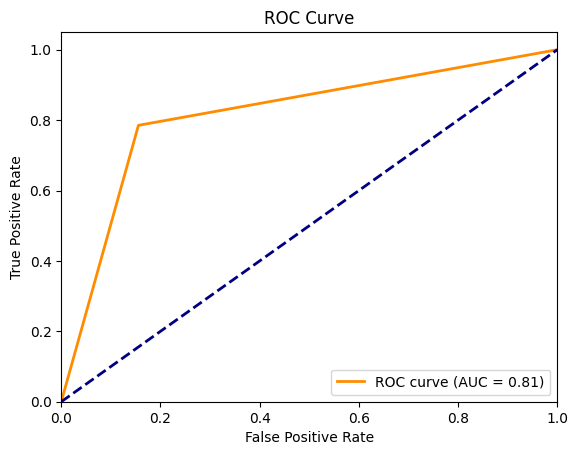

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

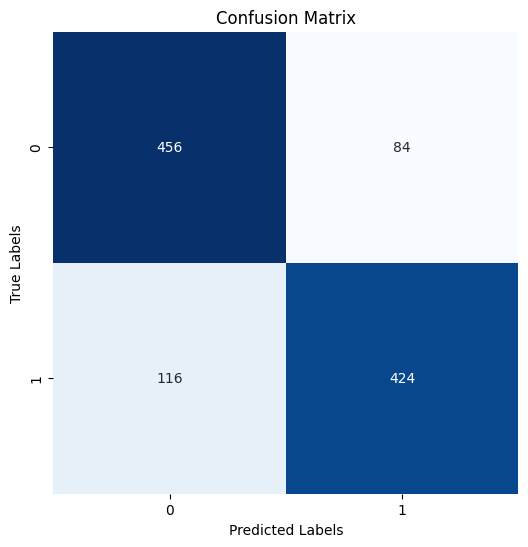

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       540
           1       0.83      0.79      0.81       540

    accuracy                           0.81      1080
   macro avg       0.82      0.81      0.81      1080
weighted avg       0.82      0.81      0.81      1080



In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [ ]:
right_folder = '/content/drive/MyDrive/Index_IMG/Img_Augmented_mask/0'
wrong_folder = '/content/drive/MyDrive/Index_IMG/Img_Augmented_mask/1'
test_folder = '/content/drive/MyDrive/Index/Img_Mask_Aug_Test'
train_folder = '/content/drive/MyDrive/Index/Img_Mask_Aug_Train'

In [ ]:
right_files = [(os.path.join(right_folder, file), 0) for file in os.listdir(right_folder) if file.endswith('.jpg')]
wrong_files = [(os.path.join(wrong_folder, file), 1) for file in os.listdir(wrong_folder) if file.endswith('.jpg')]
all_files = right_files + wrong_files

In [ ]:
len(all_files)

4681

In [ ]:
filenames = [file[0] for file in all_files]
labels = [file[1] for file in all_files]

In [ ]:
X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42)

In [ ]:
os.makedirs(test_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)

In [ ]:
for filename, label in zip(X_train_filenames, y_train):
    dst_folder = os.path.join(train_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [ ]:
for filename, label in zip(X_test_filenames, y_test):
    dst_folder = os.path.join(test_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
val_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

In [ ]:
batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
model_mask = MyLitModel(lr=0.001)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model_mask/',
    filename='mask-cnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

In [ ]:
os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer_mask = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer_mask.fit(model_mask, train_loader, val_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params
--------------------------------------------------
0 | model          | Net            | 5.4 M 
1 | train_accuracy | BinaryAccuracy | 0     
2 | val_accuracy   | BinaryAccuracy | 0     
3 | test_accuracy  | BinaryAccuracy | 0     
--------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.626    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [ ]:
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Index_IMG/Test_img_mask', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1080
    Root location: /content/drive/MyDrive/Index_IMG/Test_img_mask
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
best_model_path = checkpoint_callback.best_model_path
model = MyLitModel.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8342592716217041     │
│      test_loss_epoch      │    1.1686805486679077     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

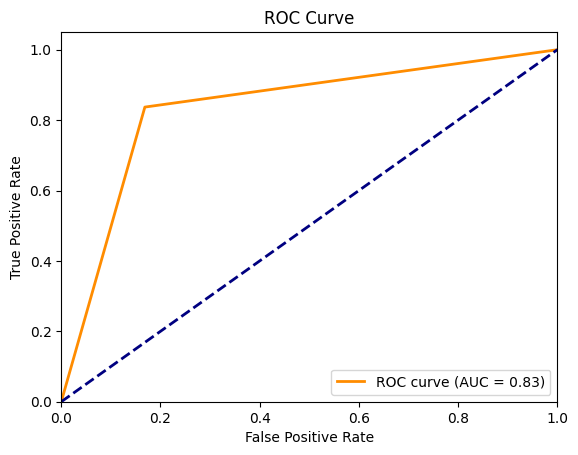

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

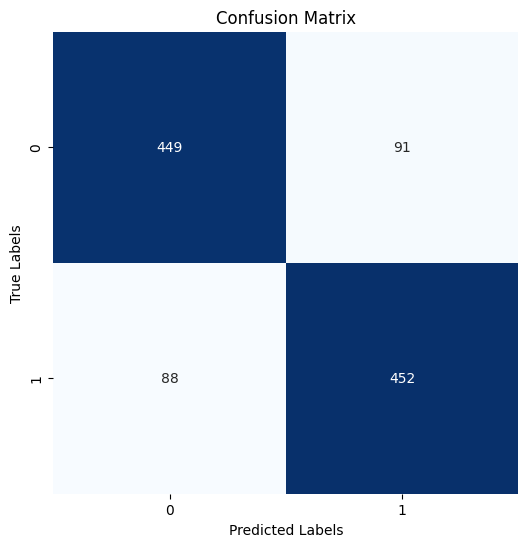

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       540
           1       0.83      0.84      0.83       540

    accuracy                           0.83      1080
   macro avg       0.83      0.83      0.83      1080
weighted avg       0.83      0.83      0.83      1080



In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [ ]:
right_folder = '/content/drive/MyDrive/Index_IMG/Img_Augmented_no_sha_mask/0'
wrong_folder = '/content/drive/MyDrive/Index_IMG/Img_Augmented_no_sha_mask/1'
test_folder = '/content/drive/MyDrive/Index/Img_no_sha_Aug_Mask_Test'
train_folder = '/content/drive/MyDrive/Index/Img_no_sha_Aug_Mask_Train'

In [ ]:
right_files = [(os.path.join(right_folder, file), 0) for file in os.listdir(right_folder) if file.endswith('.jpg')]
wrong_files = [(os.path.join(wrong_folder, file), 1) for file in os.listdir(wrong_folder) if file.endswith('.jpg')]
all_files = right_files + wrong_files

In [ ]:
len(all_files)

4681

In [ ]:
filenames = [file[0] for file in all_files]
labels = [file[1] for file in all_files]

In [ ]:
X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42)

In [ ]:
os.makedirs(test_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)

In [ ]:
for filename, label in zip(X_train_filenames, y_train):
    dst_folder = os.path.join(train_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [ ]:
for filename, label in zip(X_test_filenames, y_test):
    dst_folder = os.path.join(test_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
val_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

In [ ]:
batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
model_no_sha = MyLitModel(lr=0.001)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model_no_sha/',
    filename='no_sha-cnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

In [ ]:
os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer_mask = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer_mask.fit(model_no_sha, train_loader, val_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params
--------------------------------------------------
0 | model          | Net            | 5.4 M 
1 | train_accuracy | BinaryAccuracy | 0     
2 | val_accuracy   | BinaryAccuracy | 0     
3 | test_accuracy  | BinaryAccuracy | 0     
--------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.626    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [ ]:
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Index_IMG/Test_img_no_sha_mask', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1080
    Root location: /content/drive/MyDrive/Index_IMG/Test_img_no_sha_mask
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
best_model_path = checkpoint_callback.best_model_path
model = MyLitModel.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8305555582046509     │
│      test_loss_epoch      │    0.9591789841651917     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

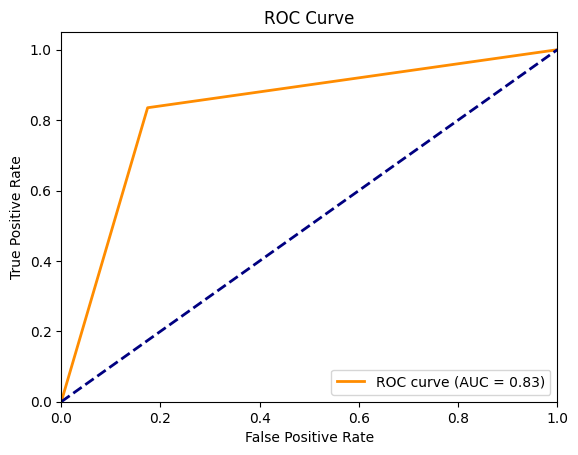

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

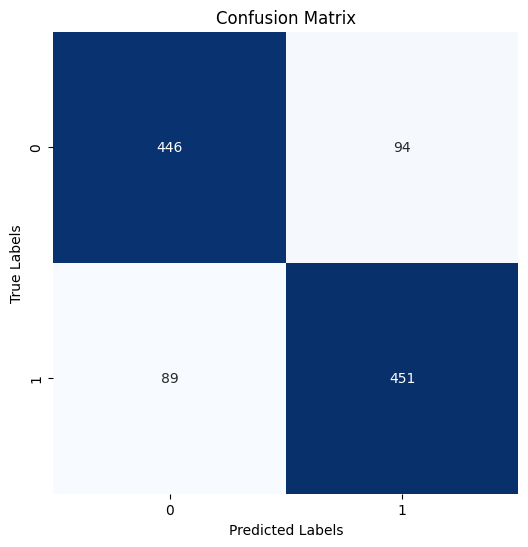

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       540
           1       0.83      0.84      0.83       540

    accuracy                           0.83      1080
   macro avg       0.83      0.83      0.83      1080
weighted avg       0.83      0.83      0.83      1080



In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [ ]:
right_folder = '/content/drive/MyDrive/Index_IMG/Img_Augmented_yc/0'
wrong_folder = '/content/drive/MyDrive/Index_IMG/Img_Augmented_yc/1'
test_folder = '/content/drive/MyDrive/Index/Img_Yc_Aug_Test'
train_folder = '/content/drive/MyDrive/Index/Img_Yc_Aug_Train'

In [ ]:
right_files = [(os.path.join(right_folder, file), 0) for file in os.listdir(right_folder) if file.endswith('.jpg')]
wrong_files = [(os.path.join(wrong_folder, file), 1) for file in os.listdir(wrong_folder) if file.endswith('.jpg')]
all_files = right_files + wrong_files

In [ ]:
len(all_files)

4681

In [ ]:
filenames = [file[0] for file in all_files]
labels = [file[1] for file in all_files]

In [ ]:
X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42)

In [ ]:
os.makedirs(test_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)

In [ ]:
for filename, label in zip(X_train_filenames, y_train):
    dst_folder = os.path.join(train_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [ ]:
for filename, label in zip(X_test_filenames, y_test):
    dst_folder = os.path.join(test_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
val_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

In [ ]:
batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
model_yc = MyLitModel(lr=0.001)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model_yc/',
    filename='yc-cnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

In [ ]:
os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer_mask = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer_mask.fit(model_no_sha, train_loader, val_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params
--------------------------------------------------
0 | model          | Net            | 5.4 M 
1 | train_accuracy | BinaryAccuracy | 0     
2 | val_accuracy   | BinaryAccuracy | 0     
3 | test_accuracy  | BinaryAccuracy | 0     
--------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.626    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [ ]:
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Index_IMG/Test_img_yc', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1080
    Root location: /content/drive/MyDrive/Index_IMG/Test_img_yc
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
best_model_path = checkpoint_callback.best_model_path
model = MyLitModel.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8259259462356567     │
│      test_loss_epoch      │    1.6206523180007935     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

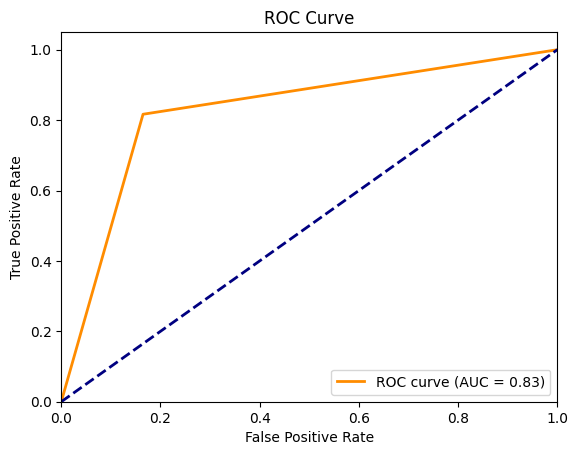

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

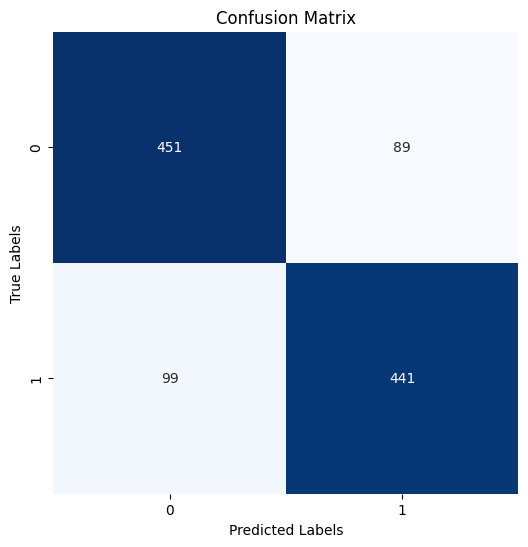

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       540
           1       0.83      0.82      0.82       540

    accuracy                           0.83      1080
   macro avg       0.83      0.83      0.83      1080
weighted avg       0.83      0.83      0.83      1080



In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [ ]:
test_folder = '/content/drive/MyDrive/Index/Img_Mask_Aug_Test'
train_folder = '/content/drive/MyDrive/Index/Img_Mask_Aug_Train'

In [ ]:
model_eva = timm.create_model('eva02_tiny_patch14_336.mim_in22k_ft_in1k', pretrained=True)
model_eva = model_eva.eval()

data_config = timm.data.resolve_model_data_config(model_eva)
train_transforms = timm.data.create_transform(**data_config, is_training=True)
val_transforms = timm.data.create_transform(**data_config, is_training=False)

train_dataset = datasets.ImageFolder(root=train_folder, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=test_folder, transform=val_transforms)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

In [ ]:
batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
class LitEva02(pl.LightningModule):
    def __init__(self, num_classes=1, lr=0.001):
        super(LitEva02, self).__init__()
        self.model = timm.create_model('eva02_tiny_patch14_336.mim_in22k_ft_in1k', pretrained=True, num_classes=num_classes)
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")
        self.lr = lr
        self.test_preds = []
        self.test_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.test_preds.append(torch.round(torch.sigmoid(preds)).cpu().numpy())
        self.test_labels.append(labels.cpu().numpy())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

In [ ]:
model_eva02_mask = LitEva02(lr=0.001)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model_eva02_mask/',
    filename='eva02_mask-cnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

In [ ]:
os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer_Eva02 = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer_Eva02.fit(model_eva02_mask, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params
--------------------------------------------------
0 | model          | Eva            | 5.6 M 
1 | train_accuracy | BinaryAccuracy | 0     
2 | val_accuracy   | BinaryAccuracy | 0     
3 | test_accuracy  | BinaryAccuracy | 0     
--------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.255    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Index_IMG/Test_img_mask', transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
best_model_path = '/content/eva02_mask-cnn-epoch=11-val_loss=0.00.ckpt'
model = LitEva02.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
